# Sentiment Analysis on Movie Reviews using KNN Classifier

In [1]:
#Importing all the neccessary libraries
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, neighbors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.model_selection import cross_validate
#from sklearn import cross_validation
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import scikitplot.metrics as sciplot
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
import math
from sklearn.decomposition import TruncatedSVD

<b> Data Source: <b> https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews

### Attribute Information: 

1. Phrase Id
2. Sentiment Id
3. Phrase
4. Sentiment

#### Objective: 

Our main objective for this analysis is to train a model which can seperate the postive and negative reviews.

#### While pre-processing the original dataset we have taken into consideration the following points.

1. We will classify a review to be positive if and only if the corresponding Score for the given review is 3 or 4.
2. We will classify a review to be negative if and only if the corresponding Score for the given review is 0 or 1.
3. We will ignore the reviews for the time being which has a Score rating of 2. Because 2 can be thought of as a neutral review. It's neither negative nor positive.
4. We will remove the duplicate entries from the dataset.
5. We will train our final model using four featurizations -> bag of words model, tf-idf model, average word-to-vec model and tf-idf weighted word-to-vec model.
6. So at end of the training the model will be trained on the above four featurizations to determine if a given review is positive or negative.

## Reading Raw Data 

In [2]:
data = pd.read_csv('data.tsv.zip', delimiter='\t')
# data= data[1:1000]
print("shape",np.shape(data))
data.head(5)

shape (156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [3]:
final_data=data
final_data['SentimentPolarity'] = final_data['Sentiment'].apply(lambda x : 'Positive' if x > 2 else 'Negative')
final_data['Class_Labels'] = final_data['SentimentPolarity'].apply(lambda x : 1 if x == 'Positive' else 0)
final_data.head()

,PhraseId,SentenceId,Phrase,Sentiment,SentimentPolarity,Class_Labels
0,1,1,A series of escapades demonstrating the adage ...,1,Negative,0
1,2,1,A series of escapades demonstrating the adage ...,2,Negative,0
2,3,1,A series,2,Negative,0
3,4,1,A,2,Negative,0
4,5,1,series,2,Negative,0


<AxesSubplot:title={'center':'Distribution Of Positive and Negative reviews'}>

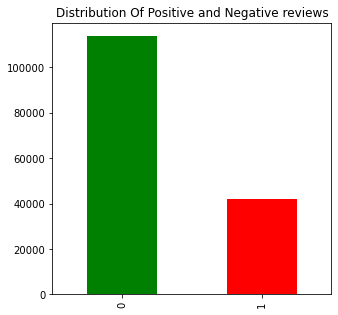

In [4]:
#Display distribution of Postive and Negative reviews in a bar graph
final_data["Class_Labels"].value_counts().plot(kind='bar',color=['green','red'],title='Distribution Of Positive and Negative reviews',figsize=(5,5))

## Preprocessing 

### Preprocessing Review 

Our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews

In [5]:
#Printing some random reviews.
sent_1 = final_data['Phrase'].values[0]
print(sent_1)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[0]))
print("="*215)

sent_2 = final_data['Phrase'].values[1000]
print(sent_2)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[1000]))
print("="*215)

sent_3 = final_data['Phrase'].values[1500]
print(sent_3)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[1500]))
print("="*215)

sent_4 = final_data['Phrase'].values[4900]
print(sent_4)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[4900]))
print("="*215)

sent_5 = final_data['Phrase'].values[12566]
print(sent_5)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[12566]))
print("="*215)


A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .
Review Polarity: Negative
to avoid
Review Polarity: Negative
convolutions
Review Polarity: Negative
pointless extremes
Review Polarity: Negative
Dignified CEO 's meet at a rustic retreat and pee against a tree .
Review Polarity: Negative


In [6]:
#Remove urls from text python: https://stackoverflow.com/a/40823105/4084039
import re
sent_1 = re.sub(r"http\S+", " ", sent_1)
sent_2 = re.sub(r"http\S+", " ", sent_2)
sent_3 = re.sub(r"http\S+", " ", sent_3)
sent_4 = re.sub(r"http\S+", " ", sent_4)
sent_5 = re.sub(r"http\S+", " ", sent_5)


print(sent_1,"\n")
print("="*215)
print(sent_2,"\n")
print("="*215)
print(sent_3,"\n")
print("="*215)
print(sent_4,"\n")
print("="*215)
print(sent_5,"\n")
print("="*215)


A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story . 

to avoid 

convolutions 

pointless extremes 

Dignified CEO 's meet at a rustic retreat and pee against a tree . 



In [7]:
#Function to clean html tags from a sentence
def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text


print(removeHtml(sent_1) + "\n")
print(removeHtml(sent_2) + "\n")
print(removeHtml(sent_3) + "\n")
print(removeHtml(sent_4) + "\n")
print(removeHtml(sent_5) + "\n")


A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .

to avoid

convolutions

pointless extremes

Dignified CEO 's meet at a rustic retreat and pee against a tree .



In [8]:
# https://stackoverflow.com/a/47091490/4084039
# https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
import re

#Expand the reviews x is aninput string of any length. Convert all the words to lower case
def decontracted(x):
    x = str(x).lower()
    x = x.replace(",000,000", " m").replace(",000", " k").replace("′", "'").replace("’", "'")\
                           .replace("won't", " will not").replace("cannot", " can not").replace("can't", " can not")\
                           .replace("n't", " not").replace("what's", " what is").replace("it's", " it is")\
                           .replace("'ve", " have").replace("'m", " am").replace("'re", " are")\
                           .replace("he's", " he is").replace("she's", " she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("how's"," how has").replace("y'all"," you all")\
                           .replace("o'clock"," of the clock").replace("ne'er"," never").replace("let's"," let us")\
                           .replace("finna"," fixing to").replace("gonna"," going to").replace("gimme"," give me").replace("gotta"," got to").replace("'d"," would")\
                           .replace("daresn't"," dare not").replace("dasn't"," dare not").replace("e'er"," ever").replace("everyone's"," everyone is")\
                           .replace("'cause'"," because")
    
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    return x

In [9]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
'''
>>> import re
>>> s = "ABCD abcd AB55 55CD A55D 5555"
>>> re.sub("\S*\d\S*", "", s).strip()

'ABCD abcd'
>>>'''

sent_1 = re.sub("\S*\d\S*", " ", sent_1).strip()
print(sent_1)

A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .


In [10]:
'''Data Cleaning Stage.'''
#Data Cleaning Stage. Clean each review from the sampled Amazon Dataset

''' pattern = re.compile('<.*?>') #Function to clean html tags from a sentence
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text'''

#Remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
def removeNumbers(sentence):
    sentence = re.sub("\S*\d\S*", " ", sentence).strip()
    return (sentence)

#Function to clean html tags from a sentence
def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text

#Remove URL from sentences.
def removeURL(sentence):
    text = re.sub(r"http\S+", " ", sentence)
    sentence = re.sub(r"www.\S+", " ", text)
    return (sentence)
    
#Function to keep only words containing letters A-Z and a-z. This will remove all punctuations, special characters etc. https://stackoverflow.com/a/5843547/4084039
def removePunctuations(sentence):
    cleaned_text  = re.sub('[^a-zA-Z]',' ',sentence)
    return (cleaned_text)

#https://stackoverflow.com/questions/37012948/regex-to-match-an-entire-word-that-contains-repeated-character
#Remove words like 'zzzzzzzzzzzzzzzzzzzzzzz', 'testtting', 'grrrrrrreeeettttt' etc. Preserves words like 'looks', 'goods', 'soon' etc. We will remove all such words which has three consecutive repeating characters.
def removePatterns(sentence): 
    cleaned_text  = re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',sentence)
    return (cleaned_text)

In [11]:
#Stemming and stopwords removal
from nltk.stem.snowball import SnowballStemmer
sno = SnowballStemmer(language='english')

#Removing the word 'not' from stopwords
default_stopwords = set(stopwords.words('english'))
remove_not = set(['no', 'nor', 'not'])
custom_stopwords = default_stopwords - remove_not

100%|███████████████████████████████████████████████████████████████████████| 10221/10221 [00:00<00:00, 1023149.91it/s]


Text(0, 0.5, 'Number of Words')

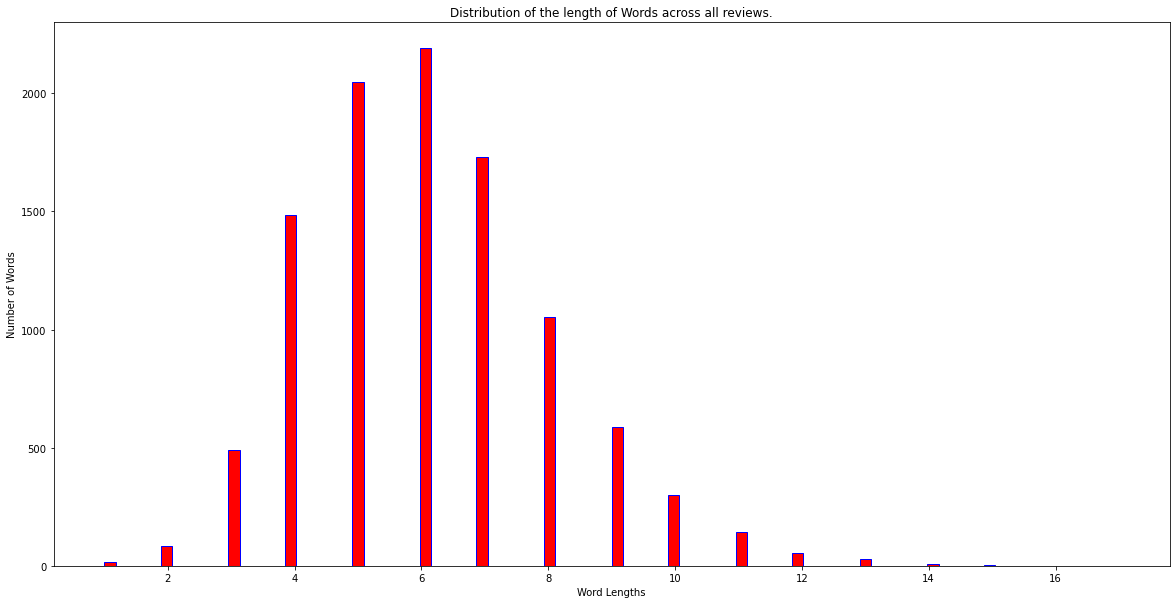

In [12]:
#We will check the distribution of stemmed word lengths across the whole review dataset to understand what is the length of the maximum number of words we will consider for the word to be relevant.
#In other words we will keep only those words which has a length less than that of a speicific length (we will obtain this specific length from the histogram).
from tqdm import tqdm
total_words = []

for review in tqdm(final_data['Phrase'].values):
    filtered_sentence=[]
    review = decontracted(review)
    review = removeNumbers(review)
    review = removeHtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    
    for cleaned_words in review.split():   
        if((cleaned_words not in custom_stopwords)):          
            stemed_word=(sno.stem(cleaned_words.lower()))
            total_words.append(stemed_word)

total_words = list(set(total_words)) #Get list of unique words.

#A list to hold the length of each words used in all the reviews used across the whole dataset.
dist = []
for i in tqdm(total_words):
    length = len(i)
    dist.append(length)

# matplotlib histogram to see the distribution of the length of words
plt.figure(figsize=(20,10))
plt.hist(dist, color = 'red', edgecolor = 'blue', bins =90)
plt.title('Distribution of the length of Words across all reviews.')
plt.xlabel('Word Lengths')
plt.ylabel('Number of Words')

### Conclusion from the above histogram: 

We can see that most stemmed words present in the reviews has lengths between 3 and 10. Words which has length greater than 13 are very very very few as compared to other words. So we will discard these words from the reviews when we process them. It means we will consider only those words whose length is greater than 2 and less than 13.

In [13]:
# Combining all the above data cleaning methodologies as discussed above.

#Processing review Texts
preprocessed_reviews = [] #Store all the processed reviews
all_positive_words=[] #Store all the relevant words from Positive reviews
all_negative_words=[] #Store all the relevant words from Negative reviews
 
count=0     #Iterator to iterate through the list of reviews and check if a given review belongs to the positive or negative class
string=' '    
stemed_word=' '

for review in tqdm(final_data['Phrase'].values):
    filtered_sentence=[]
    review = decontracted(review)
    review = removeNumbers(review)
    review = removeHtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    
    for cleaned_words in review.split():   
        if((cleaned_words not in custom_stopwords) and (2<len(cleaned_words)<16)):
            stemed_word=(sno.stem(cleaned_words.lower()))                                   
            filtered_sentence.append(stemed_word)
            if (final_data['SentimentPolarity'].values)[count] == 'Positive': 
                all_positive_words.append(stemed_word) #List of all the relevant words from Positive reviews
            if(final_data['SentimentPolarity'].values)[count] == 'Negative':
                all_negative_words.append(stemed_word) #List of all the relevant words from Negative reviews
        else:
            continue
    review = " ".join(filtered_sentence) #Final string of cleaned words    
    preprocessed_reviews.append(review.strip()) #Data corpus contaning cleaned reviews from the whole dataset
    count+=1
    
#Save the list of positive words and negative words
import pickle
with open('all_positive_words.pkl', 'wb') as file:
    pickle.dump(all_positive_words, file)
    
with open('all_negative_words.pkl', 'wb') as file:
    pickle.dump(all_negative_words, file)
    
#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
final_data['CleanedText']=preprocessed_reviews 
    
print("The length of the data corpus is : {}".format(len(preprocessed_reviews)))

#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
final_data['CleanedText']=preprocessed_reviews

100%|████████████████████████████████████████████████████████████████████████| 156060/156060 [00:28<00:00, 5472.28it/s]


The length of the data corpus is : 156060


### In this code block : 

1. We define a function which is used to seperate the positive and the negative data points for any input dataset using their corresponding class labels, using KNN algorithm.
2. We split the input dataset into train set and test set. For the training set I have taken the old 80% data. For the test set I have taken the latest 20% data. The idea here is to see how the model behaves when it's tested on 'new unseen' data after getting trained on an old data.
3. We use cross validation to determine the optimal value of K, and use this value of K as our number nearest neighbours to train the final model.
4. Finally, we will use accuracy as a metric to evaluate this models performance on unseen data.

In [14]:
def knn_algorithm(X_train, y_train, X_test, y_test, vectorizationType):
    '''This function splits the dataset into training set and test sets. The test data remains untouched.
    A 10 fold cross validation is performed on the train data and the value of optimal K is calculated. 
    The dataset is then trained with this value of optimal k. 
    Finally the knn model is used to predict its accuracy on the future unseen test set.'''
        
    X_train = X_train ; y_train = y_train #Train dataframe
    X_test = X_test ; y_test = y_test #Test Dataframe
    
    #algorithms = ['brute','kd_tree']
    algorithms = ['brute']
    
    for algo in algorithms:
                
        print("\nStarting Cross Validation steps for {} model using {} algorithm.".format(vectorizationType, algo.upper()))
        
        #Creating an odd number list of different K values for KNN.
        k_values = list(np.arange(1,50,2))

        #Create an empty list that will hold the mean of cross validation accuracy scores for each value of k in the CV step.
        cross_val_scores = []
        
        if algo == 'kd_tree':
            svd = TruncatedSVD(n_components = 100)
            X_train = svd.fit_transform(X_train)
            X_test = svd.fit_transform(X_test)
            
        #Perform 10-fold cross validation on the train set 
        for k in k_values:
            knn_classifier = KNeighborsClassifier(n_neighbors=k, weights='distance', algorithm=algo, p=2, metric='minkowski', n_jobs=6)
            accuracies = cross_val_score(knn_classifier, X_train, y_train, cv=10, scoring='accuracy')
            cross_val_scores.append(accuracies.mean())
            #print("Cross validation completed using k = {}".format(k))
        
        #Changing accuracy to error. **error = 1 - accuracy
        errors = [1 - x for x in cross_val_scores]

        #Determining best k from errors. K will be best for the lowest value for error.
        optimal_k = k_values[errors.index(min(errors))]
        print('\nThe optimal number of neighbors for {} algorithm is : {}'.format(algo.upper(),optimal_k))  

        #Plot errors vs k values
        plt.figure(figsize=(12,6))
        plt.plot(k_values , errors, color='green', linestyle='dashed', linewidth=2, marker='o', markerfacecolor='red', markersize=10)
        for xy in zip(k_values, np.round(errors,3)):
            plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
        plt.title('Plot for Errors vs K Values')
        plt.xlabel('Number of Neighbors K for {} algorithm'.format(algo.upper()))
        plt.ylabel('Errors')
        plt.show()
    
        print("The error for each k value when using {} algorithm: {}".format(algo.upper(),np.round(errors,3)))


        '''Train the model using the optimal value of k found from the previous step and evaluate it's accuracy on the test set(unseen data).'''

        #Initialize the KNN model, where k = optimal_k
        knn_classifier = KNeighborsClassifier(n_neighbors=optimal_k, weights='distance', algorithm='kd_tree', p=2, metric='minkowski', n_jobs=6)

        #Fit the model to the train set
        knn_classifier.fit(X_train, y_train)

        #Predict the labels for the test set.
        y_pred = knn_classifier.predict(X_test)

        '''PERFORMANCE EVALUATION'''

        print("\n'''PERFORMANCE EVALUATION FOR {} model'''".format(vectorizationType))

        print("\n\nDetailed report for the {} Vectorization using {} algorithm:".format(algo.upper(),vectorizationType))

        #Evaluate the accuracy of the model on test set
        test_accuracy = accuracy_score(y_test, y_pred, normalize=True) * 100
        points = accuracy_score(y_test, y_pred, normalize=False)
        print('The number of accurate predictions out of {} data points on unseen data for K = {} is {}'.format(X_test_vectors.shape[0],optimal_k, points))
        print('\nAccuracy of the KNN model using {} algorithm on unseen data for K = {} is {} %'.format(algo.upper(),optimal_k, np.round(test_accuracy,2)))

        #Get the precision, recall and F1 score for this model.
        print("Precision of the KNN model using {} algorithm on unseen data for K = {} is {}".format(algo.upper(),optimal_k, np.round(metrics.precision_score(y_test ,y_pred),4)))
        print("Recall of the KNN model using {} algorithm on unseen data for K = {} is {}".format(algo.upper(),optimal_k, np.round(metrics.recall_score(y_test ,y_pred),4)))
        print("F1 score of the KNN model using {} algorithm on unseen data for K = {} is {}".format(algo.upper(),optimal_k, np.round(metrics.f1_score(y_test ,y_pred),4)))

        #Classification Report
        print ('\nClasification report for {} model is using {} algorithm : \n'.format(vectorizationType,algo.upper()))
        print(metrics.classification_report(y_test,y_pred))

        #Inference
        print("\nOf all the reviews that the model has predicted to be positive, {}% of them are actually positive.".format(np.round(metrics.precision_score(y_test ,y_pred)*100,2)))
        print("Of all the reviews that are actually positive, the model has predicted {}% of them to be positive.".format(np.round(metrics.recall_score(y_test ,y_pred)*100,2)))

        #Get the confusion matrix for the running model
        print("\nFind below the confusion matrix for {} model using {} algorithm.".format(vectorizationType,algo.upper()))
        sciplot.plot_confusion_matrix(y_test ,y_pred)
        
        #Save the below list for later use to display model information
        info_model_KNN = [vectorizationType, optimal_k, np.round(np.array(errors).mean(),4), np.round(1-metrics.accuracy_score(y_test, y_pred),4), np.round(metrics.f1_score(y_test ,y_pred),4)]
        with open('info_model_KNN.txt', 'a') as filehandle:  
            filehandle.writelines("%s " % iterator for iterator in info_model_KNN)
            filehandle.writelines("\n")
            
        #Freeing memory allocations    
        del(X_train, y_train, X_test, y_test, y_pred, knn_classifier)

### KNN on the Bag of Words model created using 'CleanedText'. 

A bag-of-words model, or BoW for short, is a way of extracting features from text for use in modeling, such as with machine learning algorithms. The approach is very simple and flexible, and can be used in a myriad of ways for extracting features from documents. Suppose we have N reviews in our dataset and we want to convert the words in our reviews to vectors. We can use BOW as a method to do this. What it does is that for each unique word in the data corpus, it creates a dimension. Then it counts how many number of times a word is present in a review. And then this number is placed under that word for a corresponding review. We will get a Sparse Matrix representation for all the worods in the review.


Creating the BOW vectors using the cleaned corpus
The shape of the X_train_vectors is : (40000, 5052)
The shape of the X_test_vectors is : (10000, 5052)

Starting Cross Validation steps for Bag-of-Words model using BRUTE algorithm.

The optimal number of neighbors for BRUTE algorithm is : 15


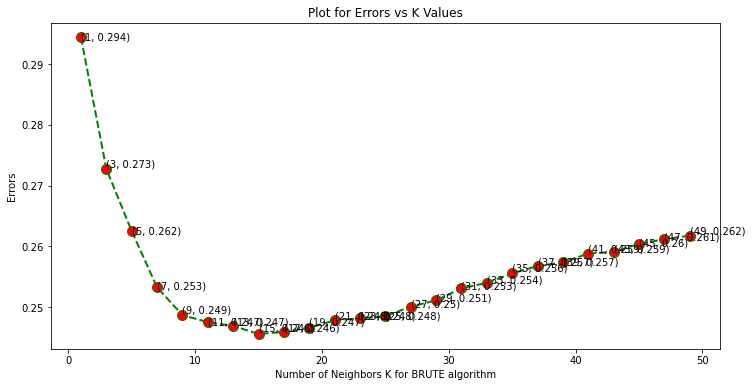

The error for each k value when using BRUTE algorithm: [0.294 0.273 0.262 0.253 0.249 0.247 0.247 0.246 0.246 0.247 0.248 0.248
 0.248 0.25  0.251 0.253 0.254 0.256 0.257 0.257 0.259 0.259 0.26  0.261
 0.262]

'''PERFORMANCE EVALUATION FOR Bag-of-Words model'''


Detailed report for the BRUTE Vectorization using Bag-of-Words algorithm:
The number of accurate predictions out of 10000 data points on unseen data for K = 15 is 7697

Accuracy of the KNN model using BRUTE algorithm on unseen data for K = 15 is 76.97 %
Precision of the KNN model using BRUTE algorithm on unseen data for K = 15 is 0.7412
Recall of the KNN model using BRUTE algorithm on unseen data for K = 15 is 0.2714
F1 score of the KNN model using BRUTE algorithm on unseen data for K = 15 is 0.3973

Clasification report for Bag-of-Words model is using BRUTE algorithm : 

              precision    recall  f1-score   support

           0       0.77      0.96      0.86      7203
           1       0.74      0.27      0.40     

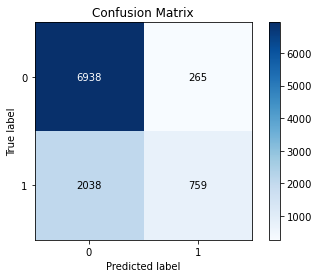

In [15]:
sampled_dataset = final_data

#Split the data set into train and test sets. The test set should be unseen. Time Based Splitting Step 2.
#The top old 80% data will get into the train set. The latest 20% data will get into the test set.
X = sampled_dataset['CleanedText']
y = sampled_dataset['Class_Labels']
#split = math.floor(0.8*len(X))
split = 40000
X_train = X[0:split,] ; y_train = y[0:split,]
X_test = X[split:50000,] ; y_test = y[split:50000,]

#Initializing the BOW constructor
cv_object = CountVectorizer().fit(X_train)

#Creating the BOW matrix from cleaned data corpus. Only 'not' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the BOW vectors using the cleaned corpus")
X_train_vectors = cv_object.transform(X_train)
X_test_vectors = cv_object.transform(X_test)

#Colum Standardization of the Bag of Words vector created using cleaned data. This is done for both train and test Vectors.
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler(with_mean=False)
scalar.fit(X_train_vectors)
X_train_vectors = scalar.transform(X_train_vectors)
X_test_vectors = scalar.transform(X_test_vectors)
print("The shape of the X_train_vectors is : {}".format(X_train_vectors.shape))
print("The shape of the X_test_vectors is : {}".format(X_test_vectors.shape))

#Free memory allocations.
del(sampled_dataset, X, y, X_train, X_test)

#Fitting the KNN to the BOW model
knn_algorithm(X_train_vectors, y_train, X_test_vectors, y_test, "Bag-of-Words")

### KNN on the TF-IDF model created using 'CleanedText' texts

In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

Let's assume we have data corpus D, which contains N reviews {r1,r2,r3,r4...rN}. Let's say our review r1 contains the following words {w1,w2,w3,w1,w9,w6,w7,w9,w9}.

TF or Term Frequency for a word is basically the number of times a word occurs in a review divided by the total number of words present in that same review. For example, in the text corpus that we have considered in the above example, the TF for word w1 is (2/9) and for word w9 is (1/3). Intuitively, higher the occurence of a word in a text is, greater will be its TF value. TF values lies between 0 and 1.

IDF or Inverse Document Frequency for a word is given by the formula log(N/n), where 'N' is equal to the total number of reviews in the corpus 'D' and 'n' refers to the number of reviews in 'D' which contains that specific word. Intuitively, IDF will be higher for words which occur rarely and will be less for words which occurs more frequently. IDF values are more than 0.

So for each word in each review we will consider the product of (TF x IDF), and represent it in a d dimensional vector.

TF-IDF basically doesn't consider the semantic meaning of words. But what is does is that it gives more importance to words which occurs less frequently in the whole data corpus and also gives much importance to the most frequent words that occurs in each review.


Creating the BOW vectors using the cleaned corpus
The shape of the X_train_vectors is : (40000, 5052)
The shape of the X_test_vectors is : (10000, 5052)

Starting Cross Validation steps for TF-IDF model using BRUTE algorithm.

The optimal number of neighbors for BRUTE algorithm is : 19


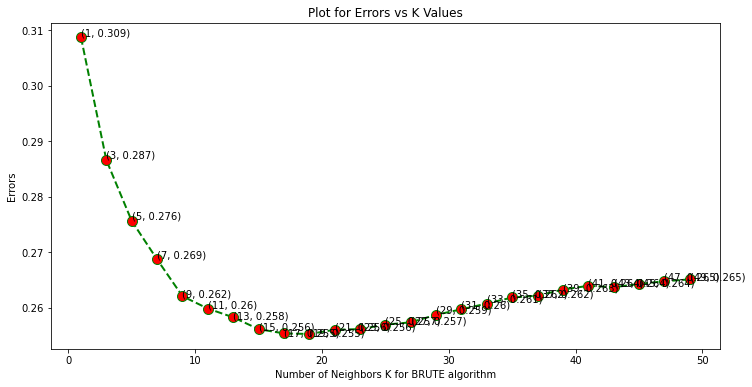

The error for each k value when using BRUTE algorithm: [0.309 0.287 0.276 0.269 0.262 0.26  0.258 0.256 0.255 0.255 0.256 0.256
 0.257 0.257 0.259 0.26  0.261 0.262 0.262 0.263 0.264 0.264 0.264 0.265
 0.265]

'''PERFORMANCE EVALUATION FOR TF-IDF model'''


Detailed report for the BRUTE Vectorization using TF-IDF algorithm:
The number of accurate predictions out of 10000 data points on unseen data for K = 19 is 7575

Accuracy of the KNN model using BRUTE algorithm on unseen data for K = 19 is 75.75 %
Precision of the KNN model using BRUTE algorithm on unseen data for K = 19 is 0.709
Recall of the KNN model using BRUTE algorithm on unseen data for K = 19 is 0.2256
F1 score of the KNN model using BRUTE algorithm on unseen data for K = 19 is 0.3423

Clasification report for TF-IDF model is using BRUTE algorithm : 

              precision    recall  f1-score   support

           0       0.76      0.96      0.85      7203
           1       0.71      0.23      0.34      2797

    accuracy

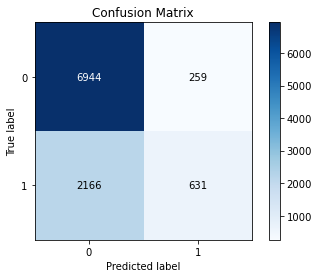

In [16]:
'''TF-IDF model creation using text reviews. HTML tags and punctuations are removed. All stopwords are preserved.'''


sampled_dataset = final_data

#Split the data set into train and test sets. The test set should be unseen. Time Based Splitting Step 2.
#The top old 80% data will get into the train set. The latest 20% data will get into the test set.
X = sampled_dataset['CleanedText']
y = sampled_dataset['Class_Labels']
#split = math.floor(0.8*len(X))
split = 40000
X_train = X[0:split,] ; y_train = y[0:split,]
X_test = X[split:50000,] ; y_test = y[split:50000,]

#Initializing the TF-IDF contructor
tf_idf_object = TfidfVectorizer(ngram_range=(1,1)).fit(X_train)

#Creating the BOW matrix from cleaned data corpus. Only 'not' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the BOW vectors using the cleaned corpus")
X_train_vectors = tf_idf_object.transform(X_train)
X_test_vectors = tf_idf_object.transform(X_test)

#Colum Standardization of the TF-IDF vector created using cleaned data. This is done for both train and test Vectors.
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler(with_mean=False)
scalar.fit(X_train_vectors)
X_train_vectors = scalar.transform(X_train_vectors)
X_test_vectors = scalar.transform(X_test_vectors)
print("The shape of the X_train_vectors is : {}".format(X_train_vectors.shape))
print("The shape of the X_test_vectors is : {}".format(X_test_vectors.shape))

#Free memory allocations.
del(sampled_dataset, X, y, X_train, X_test)

#Fitting the KNN to the TF-IDF model
knn_algorithm(X_train_vectors, y_train, X_test_vectors, y_test, "TF-IDF")

### KNN on the Average Word2Vec using a 100 dimensional vector representation of each word. 

In this model we convert each word present in a review to vectors. For each sentence we will compute the average word to vec representation. Let's look at the below demo example.

Suppose we have N words in a sentence {w1,w2,w3,w4,w5,w6 ... , wN}. We will convert each word to a vector, sum them up and divide by the total number of words (N) present in that particular sentence. So our final vector will look like (1/N) * [word2vec(w1) + word2vec(w2) + word2vec(w3) .... + word2vec(wN)]

The size of the Word2Vec text corpus :  40000

The number of words that occured minimum 5 times :  4782

The length of the sentence vectors : 40000

Size of each vector :  200
The size of the Word2Vec text corpus :  10000

The number of words that occured minimum 5 times :  2136

The length of the sentence vectors : 10000

Size of each vector :  200
The shape of the X_train_vectors is : (40000, 200)
The shape of the X_test_vectors is : (10000, 200)

Starting Cross Validation steps for Average-Word2Vec model using BRUTE algorithm.

The optimal number of neighbors for BRUTE algorithm is : 47


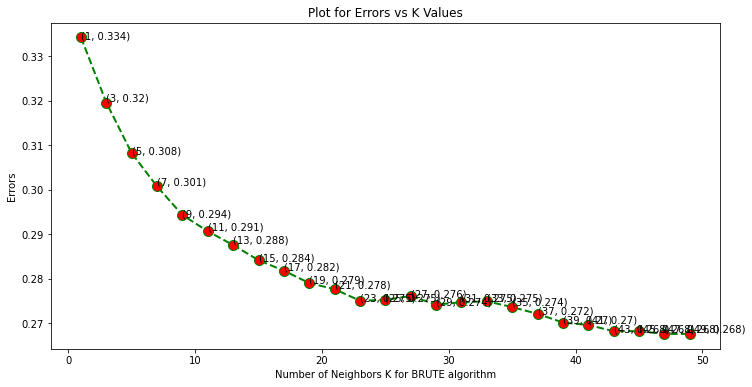

The error for each k value when using BRUTE algorithm: [0.334 0.32  0.308 0.301 0.294 0.291 0.288 0.284 0.282 0.279 0.278 0.275
 0.275 0.276 0.274 0.275 0.275 0.274 0.272 0.27  0.27  0.268 0.268 0.268
 0.268]

'''PERFORMANCE EVALUATION FOR Average-Word2Vec model'''


Detailed report for the BRUTE Vectorization using Average-Word2Vec algorithm:
The number of accurate predictions out of 10000 data points on unseen data for K = 47 is 7203

Accuracy of the KNN model using BRUTE algorithm on unseen data for K = 47 is 72.03 %
Precision of the KNN model using BRUTE algorithm on unseen data for K = 47 is 0.0
Recall of the KNN model using BRUTE algorithm on unseen data for K = 47 is 0.0
F1 score of the KNN model using BRUTE algorithm on unseen data for K = 47 is 0.0

Clasification report for Average-Word2Vec model is using BRUTE algorithm : 

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      7203
           1       0.00      0.00      0.00  

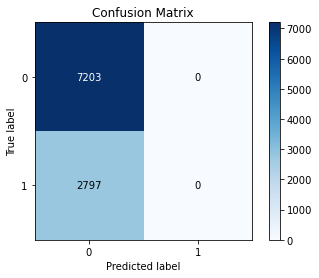

In [17]:
'''KNN using the average word2vec model on the Amazon dataset, using a 100 dimensional vector representation of each word.'''

 
sampled_dataset = final_data
#Split the data set into train and test sets. The test set should be unseen. Time Based Splitting Step 2.
#The top old 80% data will get into the train set. The latest 20% data will get into the test set.
X = sampled_dataset['CleanedText']
y = sampled_dataset['Class_Labels']
#split = math.floor(0.8*len(X))
split = 40000
X_train = X[0:split,] ; y_train = y[0:split,]
X_test = X[split:50000,] ; y_test = y[split:50000,]


#This method returns the Average Word2Vec vectors for all reviews in a given dataset
def vectorize(dataset):
    word2vec_corpus=[]
    for sentence in dataset:
        word2vec_corpus.append(sentence.split()) #Returns a list of words for each sentence for all the reviews
    print("The size of the Word2Vec text corpus : ",len(word2vec_corpus))
    
    #min_count = 5 considers only those words for our model which occurs atleast 5 times
    word2vec_model=Word2Vec(sentences=word2vec_corpus, size=200, min_count=5, workers=6)
    word2vec_words = list(word2vec_model.wv.vocab)
    print("\nThe number of words that occured minimum 5 times : ",len(word2vec_words))

    # Creating average Word2Vec model by computing the average word2vec for each review.
    sent_vectors = []; #The average word2vec for each sentence/review will be stored in this list
    for sentence in word2vec_corpus: #For each review
        sent_vec = np.zeros(200) #200 dimensional array, where all elements are zero. This is used to add word vectors and find the averages at each iteration.
        count_words =0; #This will store the count of the words with a valid vector in each review text
        for word in sentence: #For each word in a given review.
            if word in word2vec_words:
                word_vectors = word2vec_model.wv[word] #Creating a vector(numpy array of 100 dimensions) for each word.
                sent_vec += word_vectors
                count_words += 1
        if count_words != 0:
            sent_vec /= count_words
        sent_vectors.append(sent_vec)
    print("\nThe length of the sentence vectors :",len(sent_vectors))
    print("\nSize of each vector : ",len(sent_vectors[0]))
    sent_vectors = np.array(sent_vectors)
    return sent_vectors

X_train_vectors = vectorize(X_train)
X_test_vectors = vectorize(X_test)

#Colum Standardization of the average word2vec vector created using cleaned data. This is done for both train and test Vectors.
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler(with_mean=False)
scalar.fit(X_train_vectors)
X_train_vectors = scalar.transform(X_train_vectors)
X_test_vectors = scalar.transform(X_test_vectors)
print("The shape of the X_train_vectors is : {}".format(X_train_vectors.shape))
print("The shape of the X_test_vectors is : {}".format(X_test_vectors.shape))

#Free memory allocations.
del(sampled_dataset, X, y, X_train, X_test)

#Fitting the KNN to the Average Word2Vec model
knn_algorithm(X_train_vectors, y_train, X_test_vectors, y_test, "Average-Word2Vec")

### KNN on the TF-IDF weighted Average Word2Vec representation on the reviews 

In this model we convert each word present in a review to vectors. For each sentence we will compute the tf-idf average word to vec representation. Let's look at the below demo example.

Suppose we have N words in a sentence {w1,w2,w3,w4,w5,w6 ... , wN}. We will compute the tf-idf for each word in a review for all reviews. Lets say the corresponding tf-idfs are {t1,t2,t3,t4,t5,t6......tN}. We will convert each word to a vector, sum them up and divide by the summation of tf-idf vectors for all words present in that particular sentence. So our final vector will look like [1/(t1+t2+t3+t4+t5+t6+ ..... +tN)] * [word2vec(w1) + word2vec(w2) + word2vec(w3) .... + word2vec(wN)]

The shape of the X_train_vectors is : (40000, 200)
The shape of the X_test_vectors is : (10000, 200)

Starting Cross Validation steps for TF-IDF-Average-Word2Vec model using BRUTE algorithm.

The optimal number of neighbors for BRUTE algorithm is : 49


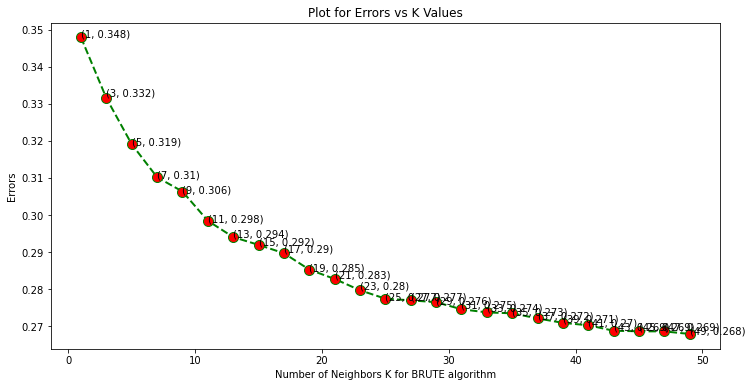

The error for each k value when using BRUTE algorithm: [0.348 0.332 0.319 0.31  0.306 0.298 0.294 0.292 0.29  0.285 0.283 0.28
 0.277 0.277 0.276 0.275 0.274 0.273 0.272 0.271 0.27  0.269 0.269 0.269
 0.268]

'''PERFORMANCE EVALUATION FOR TF-IDF-Average-Word2Vec model'''


Detailed report for the BRUTE Vectorization using TF-IDF-Average-Word2Vec algorithm:
The number of accurate predictions out of 10000 data points on unseen data for K = 49 is 7203

Accuracy of the KNN model using BRUTE algorithm on unseen data for K = 49 is 72.03 %
Precision of the KNN model using BRUTE algorithm on unseen data for K = 49 is 0.0
Recall of the KNN model using BRUTE algorithm on unseen data for K = 49 is 0.0
F1 score of the KNN model using BRUTE algorithm on unseen data for K = 49 is 0.0

Clasification report for TF-IDF-Average-Word2Vec model is using BRUTE algorithm : 

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      7203
           1       0.00  

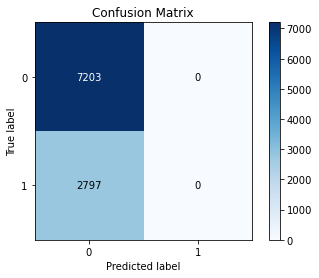

In [18]:
'''KNN using TF-IDF weighted Average Word2Vec model on the Amazon dataset.'''

sampled_dataset = final_data

#Split the data set into train and test sets. The test set should be unseen. Time Based Splitting Step 2.
#The top old 80% data will get into the train set. The latest 20% data will get into the test set.
X = sampled_dataset['CleanedText']
y = sampled_dataset['Class_Labels']
#split = math.floor(0.8*len(X))
split = 40000
X_train = X[0:split,] ; y_train = y[0:split,]
X_test = X[split:50000,] ; y_test = y[split:50000,]

#This method returns the Average Word2Vec vectors for all reviews in a given dataset
def vectorize(dataset, fit_dataset):

    #word2vec_corpus will store the list of words for each review.
    word2vec_corpus=[]
    for sentence in dataset:
        word2vec_corpus.append(sentence.split())

    #min_count = 5 considers only those words which occurs atleast 5 times
    word2vec_model=Word2Vec(sentences=word2vec_corpus, size=200, min_count=5, workers=6)
    word2vec_words = list(word2vec_model.wv.vocab)

    #Initializing the TF-IDF contructor with review texts. HTML tags and punctuations are removed. Stopwords are preserved.
    tf_idf_object = TfidfVectorizer(ngram_range=(1,1)).fit(fit_dataset)
    final_tf_idf_vectors = tf_idf_object.transform(dataset)
    tfidf_features = tf_idf_object.get_feature_names() 

    #Algorithm for finding the TF-IDF weighted average word2vec vectors.
    tfidf_sent_vectors = []; #The tfidf-w2v for each sentence/review will stored in this list
    row=0;
    for sentence in word2vec_corpus: #For each review/sentence 
        sent_vec = np.zeros(200) #200 dimensional array, where all elements are zero. This is used to add word vectors and find the averages at each iteration.
        weight_sum =0; #This will store the count of the words with a valid vector in each review text.
        for word in sentence: #For each word in a review/sentence
            if((word in word2vec_words) and (word in tfidf_features)):
                word_vectors = word2vec_model.wv[word]
                tf_idf = final_tf_idf_vectors[row, tfidf_features.index(word)] #tf_idfidf of a word in a sentence/review
                sent_vec += (word_vectors * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1

    tfidf_sent_vectors = np.array(tfidf_sent_vectors)
    return tfidf_sent_vectors

X_train_vectors = vectorize(X_train, X_train)
X_test_vectors = vectorize(X_test, X_train)

#Colum Standardization of the TF-IDF Average Word2Vec vectors created using cleaned data. This is done for both train and test Vectors.
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler(with_mean=False)
scalar.fit(X_train_vectors)
X_train_vectors = scalar.transform(X_train_vectors)
X_test_vectors = scalar.transform(X_test_vectors)
print("The shape of the X_train_vectors is : {}".format(X_train_vectors.shape))
print("The shape of the X_test_vectors is : {}".format(X_test_vectors.shape))

#Free memory allocations. 
del(X, y, X_train, X_test, sampled_dataset)

#Fitting the KNN to the TF-IDF Average Word2Vec model
knn_algorithm(X_train_vectors, y_train, X_test_vectors, y_test, "TF-IDF-Average-Word2Vec")

In [19]:
#Display information in a pretty table.
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Model", " Hyper-Parameter Value (K=)", "Train Error", "Test Error", "F1-Score"]

print("Please find below the important metrics for all the models below.\n")
file = open('info_model_KNN.txt', 'r')
file.seek(0)
for line in file:
    table.add_row(line.split())
print(table)

Please find below the important metrics for all the models below.

+-------------------------+-----------------------------+-------------+------------+----------+
|          Model          |  Hyper-Parameter Value (K=) | Train Error | Test Error | F1-Score |
+-------------------------+-----------------------------+-------------+------------+----------+
|       Bag-of-Words      |              15             |    0.2555   |   0.2303   |  0.3973  |
|       Bag-of-Words      |              15             |    0.2555   |   0.2303   |  0.3973  |
|          TF-IDF         |              19             |    0.2641   |   0.2425   |  0.3423  |
|       Bag-of-Words      |              15             |    0.2555   |   0.2303   |  0.3973  |
|          TF-IDF         |              19             |    0.2641   |   0.2425   |  0.3423  |
|       Bag-of-Words      |              15             |    0.2555   |   0.2303   |  0.3973  |
|          TF-IDF         |              19             |    0.2641  